In [8]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import os
%matplotlib inline

In [9]:
threshold_epsilon = 0.1

In [21]:
def parse_data(filename):
    keys = ['Age', 'Height', 'Weight', 'Gender']
    with open(filename) as f:
        ## collect data from file
        result = {}
        for i in range(8):
            next(f)
        for i in keys:
            tmp = f.readline()
            result[i] = tmp[(tmp.index(' ') + 1):-1]
        for i in range(4):
            next(f)
        data = []
        for r in f:
            d = r[:-1].split(', ')
            data.append([float(i) for i in d])
        
        n = len(data)
        result['duration'] = n
    
        result['X_median'] = np.median([d[1] for d in data])
        result['Y_median'] = np.median([d[2] for d in data])
        result['Z_median'] = np.median([d[3] for d in data])     
        
        ## standardizes Y data by median and X time to 0 second start
        data = list(map(lambda d : 
                        [d[0] - data[0][0], 
                         d[1] - result['X_median'], 
                         d[2] - result['Y_median'], 
                         d[3] - result['Z_median']], 
                        data))
        
        # gets useful statistics about the data
        x_data = [d[1] for d in data]
        x_min = min(x_data)
        x_max = max(x_data)  

        y_data = [d[2] for d in data]
        y_min = min(y_data)
        y_max = max(y_data)
        
        z_data = [d[3] for d in data]
        z_min = min(z_data)
        z_max = max(z_data)
        
        ## find change amount to trim
        threshold = min([abs(x_max - x_min), abs(y_max - y_min), abs(z_max - z_min)]) * threshold_epsilon
        
        (l_trim, r_trim) = trim(data, threshold)
        
        result['data'] = data
        
    return result, (l_trim, r_trim)

In [25]:
def trim(data, threshold):
    n = len(data)
    x_first = data[0][1]
    y_first = data[0][2]
    z_first = data[0][3]
    x_last = data[-1][1]
    y_last = data[-1][2]
    z_last = data[-1][3]
    
    l_trim = 0
    is_significant = False
    while not is_significant and l_trim < n - 1:
        if (abs(data[l_trim][1] - x_first) > threshold
        or abs(data[l_trim][2] - y_first) > threshold
        or abs(data[l_trim][3] - z_first) > threshold):
            is_significant = True
        else:
            l_trim += 1
            
    r_trim = n - 1
    is_significant = False
    while not is_significant and r_trim > 0:
        if (abs(data[r_trim][1] - x_last) > threshold
        or abs(data[r_trim][2] - y_last) > threshold
        or abs(data[r_trim][3] - z_last) > threshold):
            is_significant = True
        else:
            r_trim -= 1
            
    return (l_trim, r_trim)

In [26]:
def plot_data(data, bounds=None):
    n = len(data['data'])
    Xs = [data['data'][i][0] for i in range(n)]
    Ys = [data['data'][i][1] for i in range(n)]
    plt.plot(Xs, Ys, c="r")
    Ys = [data['data'][i][2] for i in range(n)]
    plt.plot(Xs, Ys, c="g")
    Ys = [data['data'][i][3] for i in range(n)]
    plt.plot(Xs, Ys, c="b")
    if bounds is not None:
        y_bounds = list(plt.gca().get_ylim())
        plt.plot([data['data'][bounds[0]][0], data['data'][bounds[0]][0]], y_bounds, c='black')
        plt.plot([data['data'][bounds[1]][0], data['data'][bounds[1]][0]], y_bounds, c='black')
    plt.show()

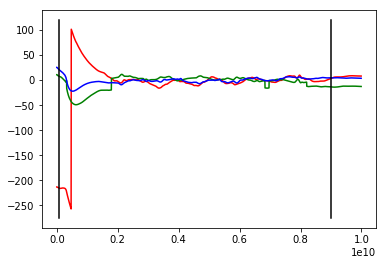

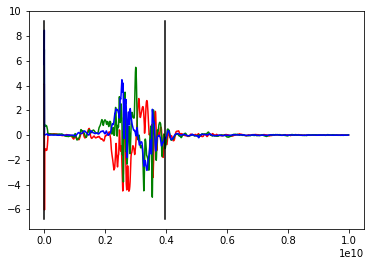

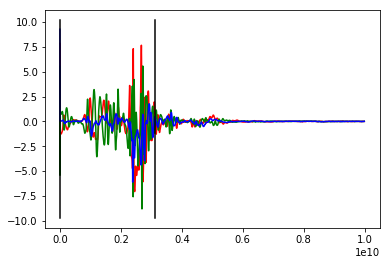

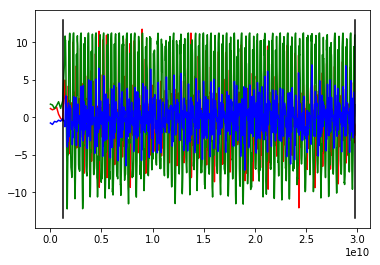

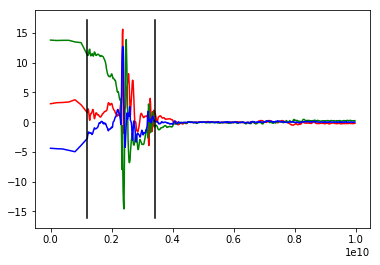

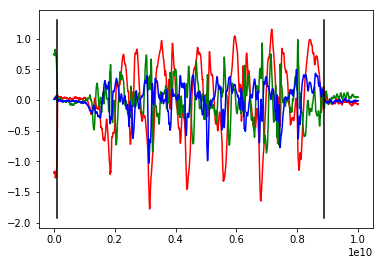

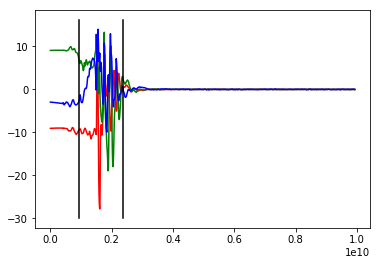

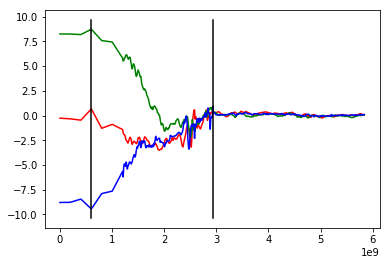

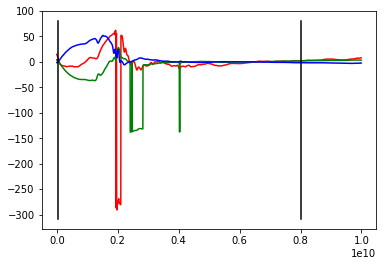

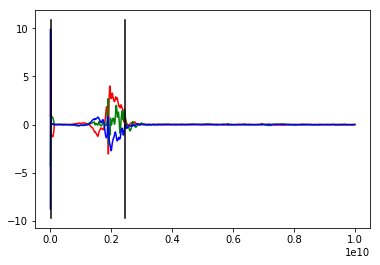

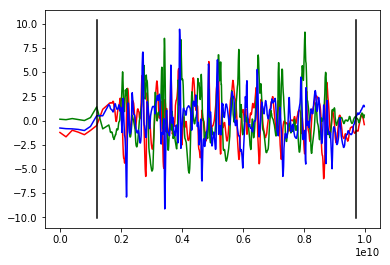

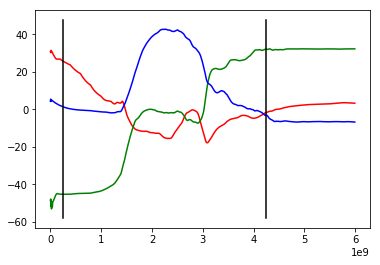

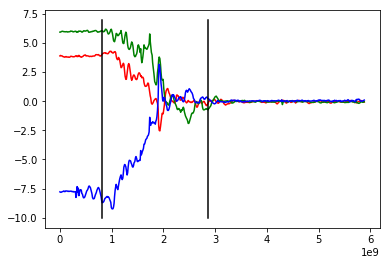

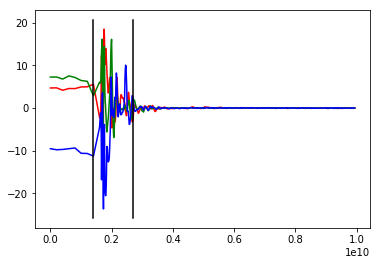

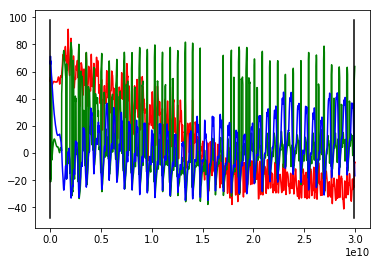

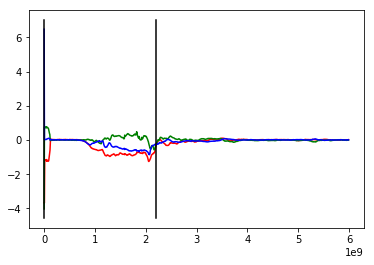

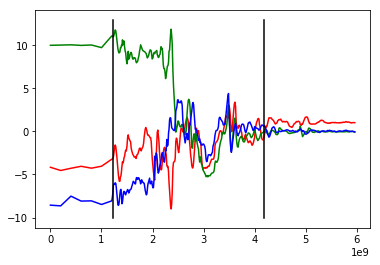

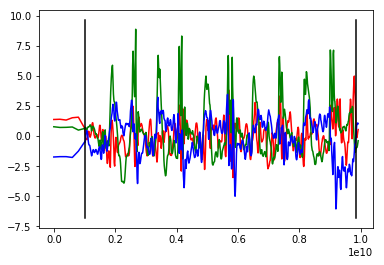

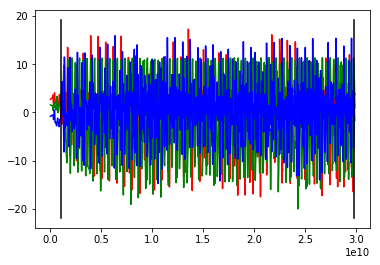

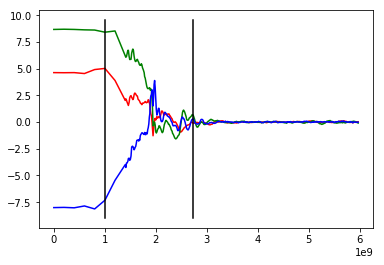

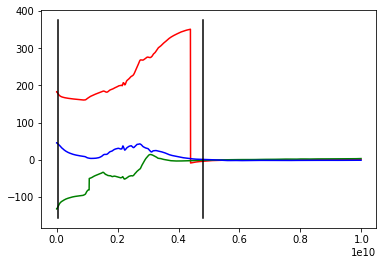

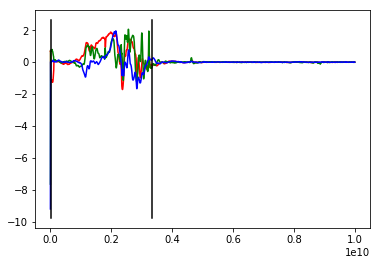

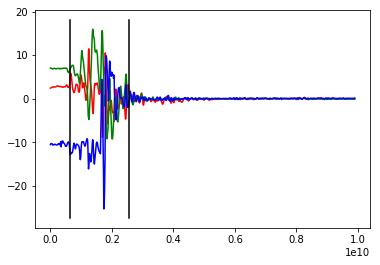

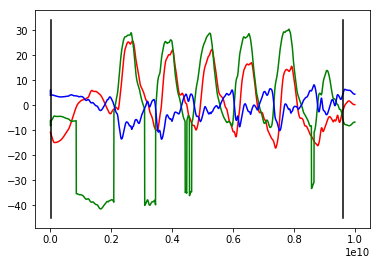

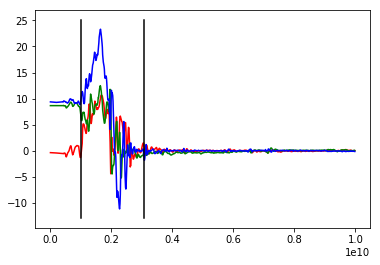

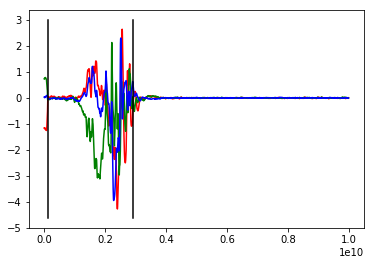

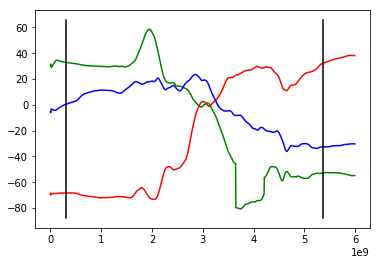

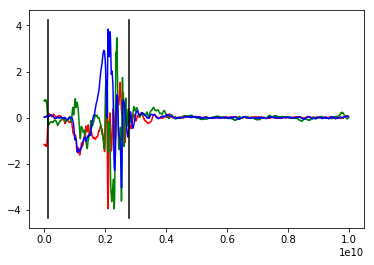

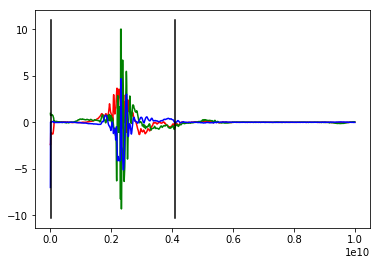

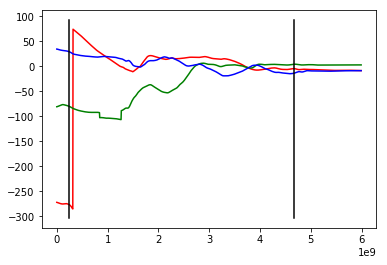

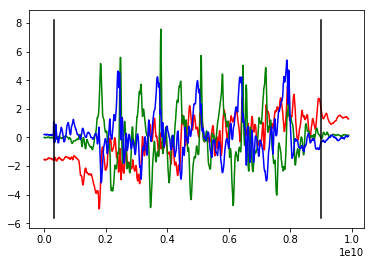

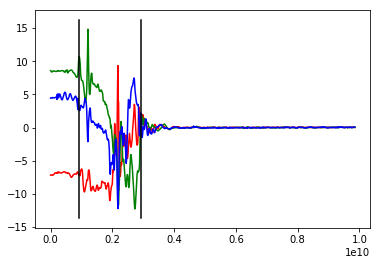

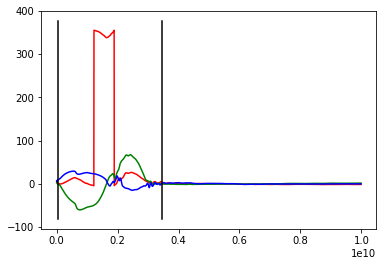

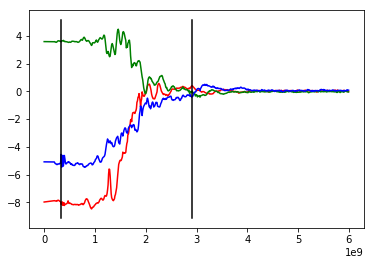

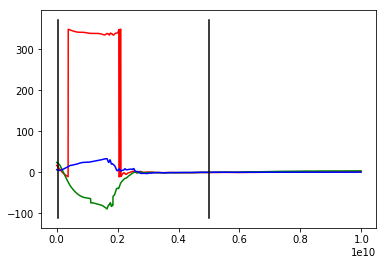

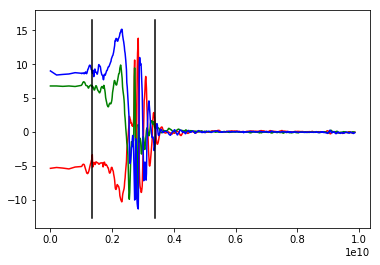

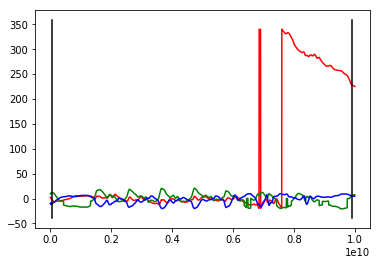

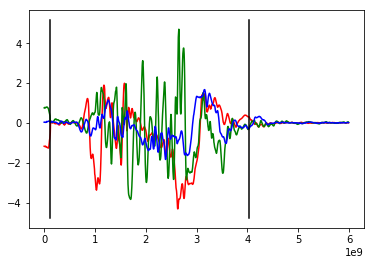

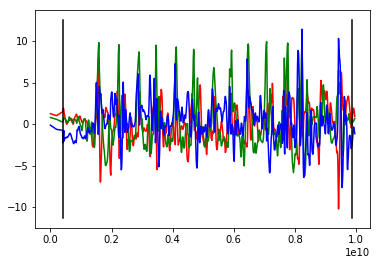

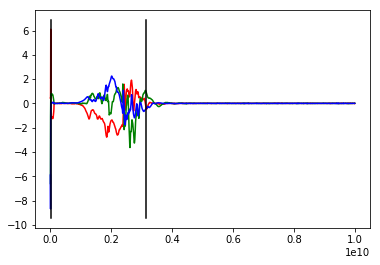

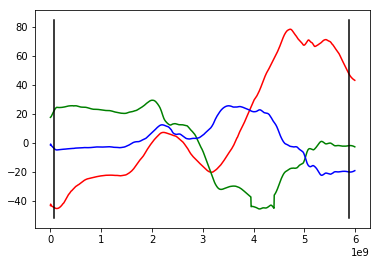

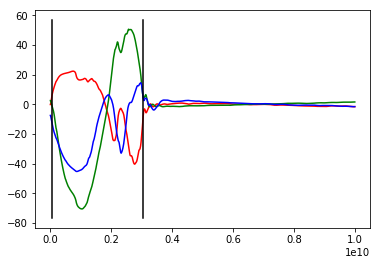

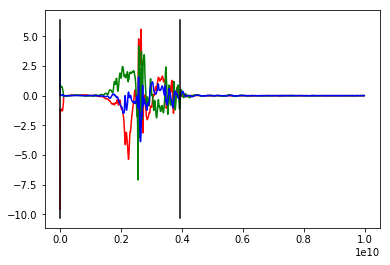

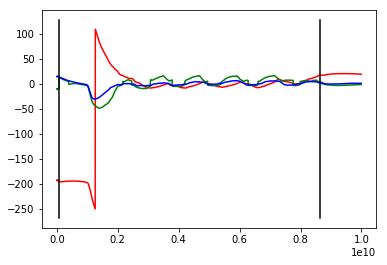

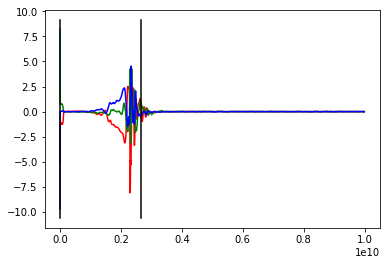

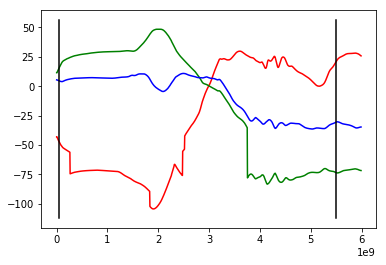

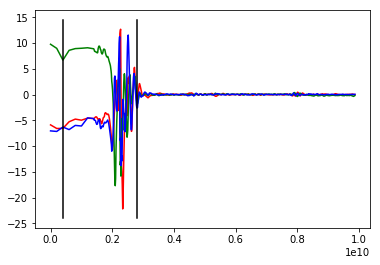

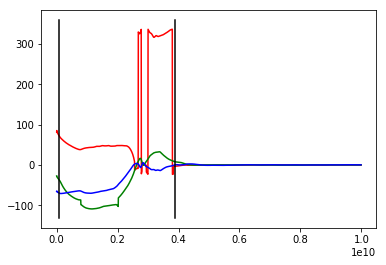

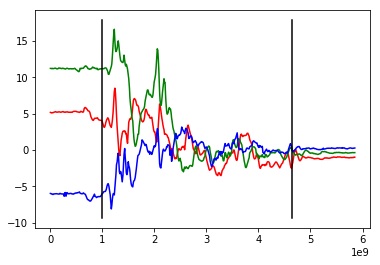

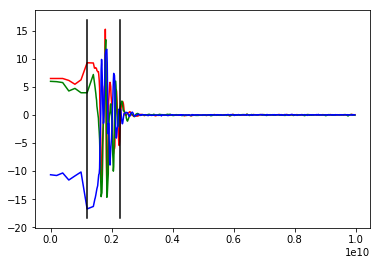

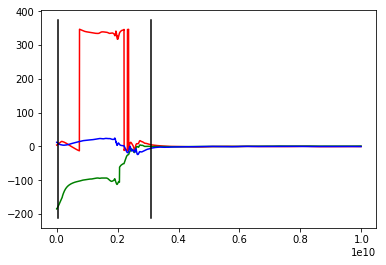

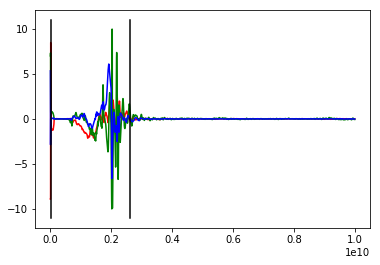

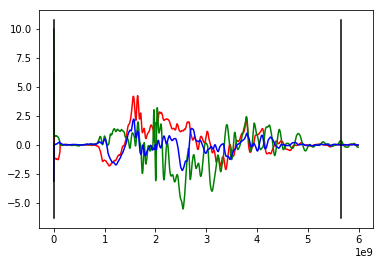

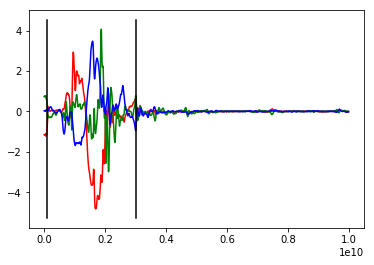

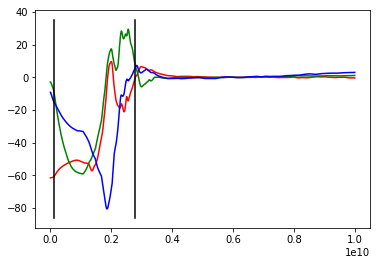

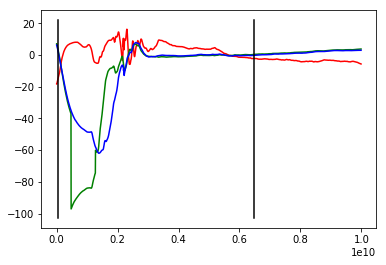

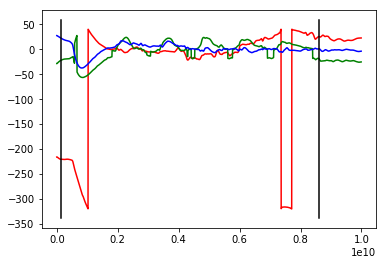

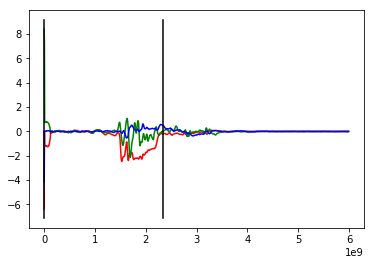

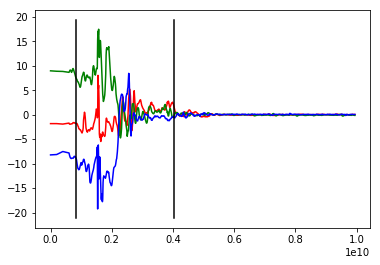

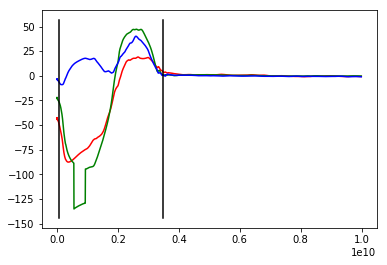

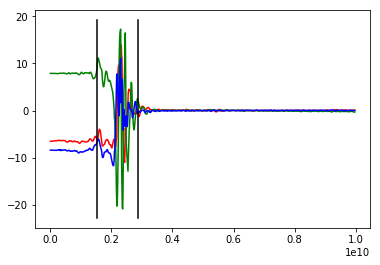

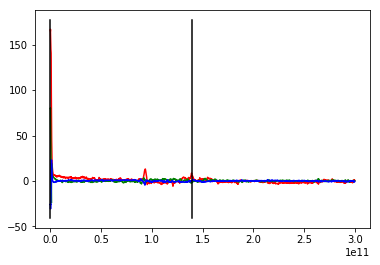

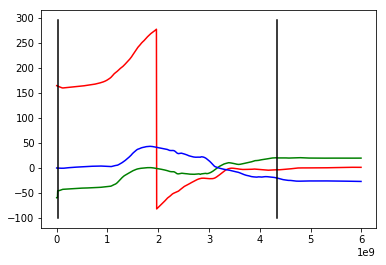

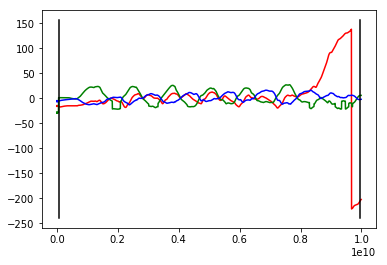

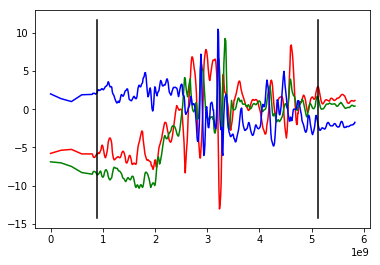

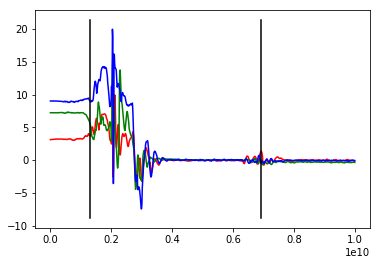

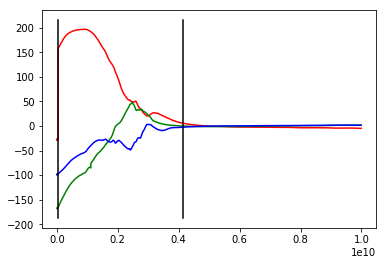

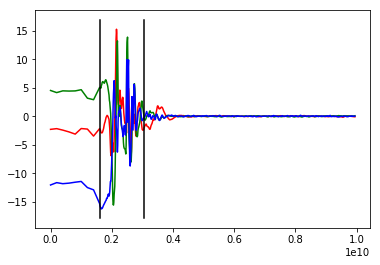

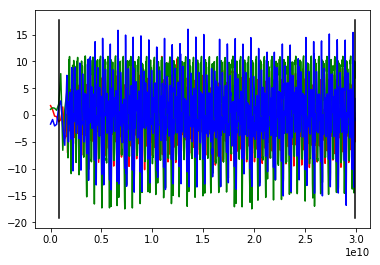

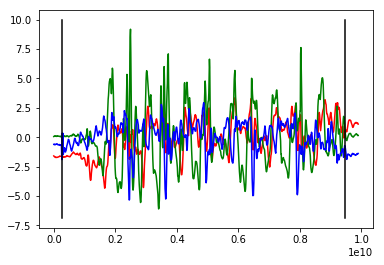

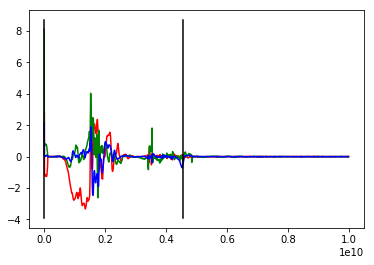

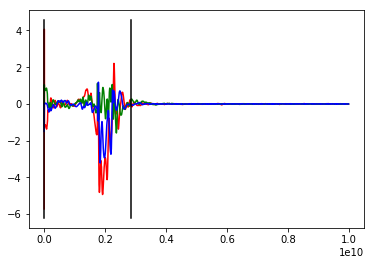

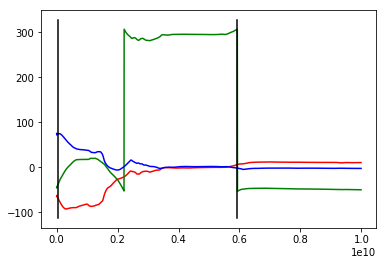

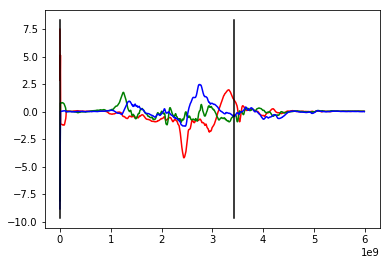

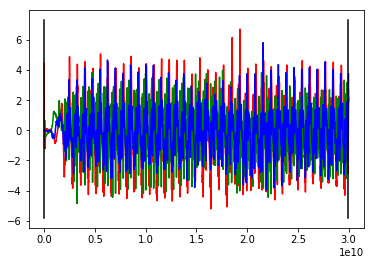

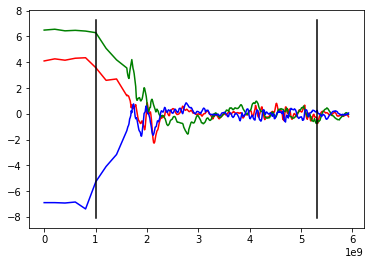

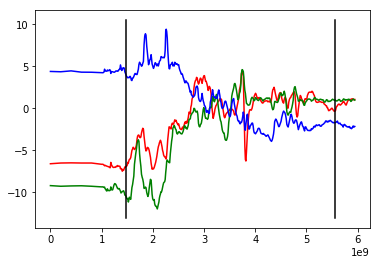

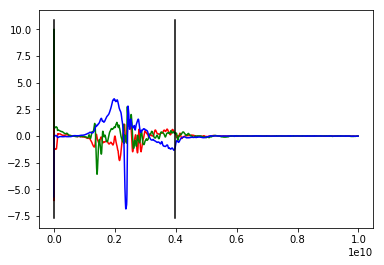

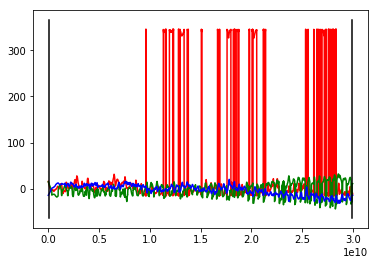

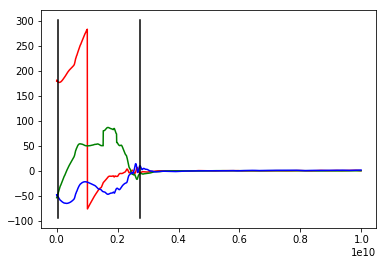

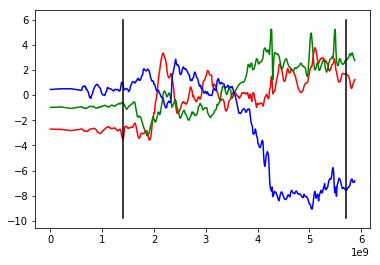

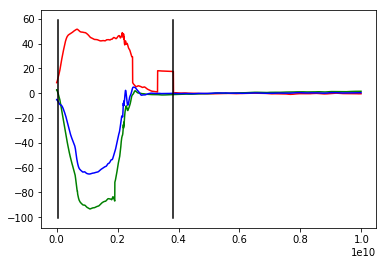

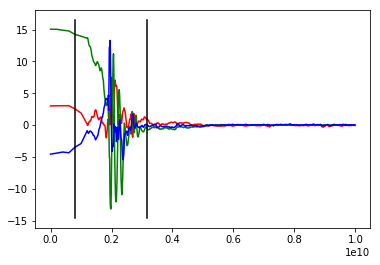

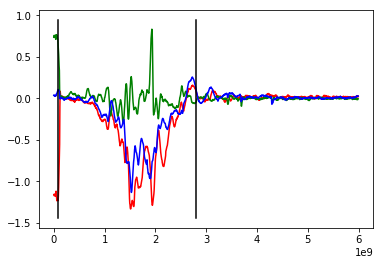

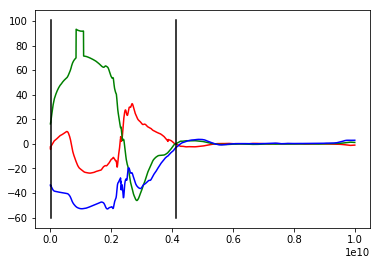

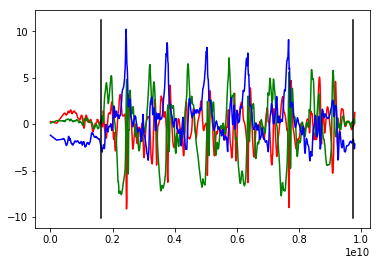

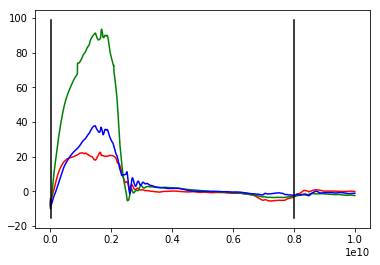

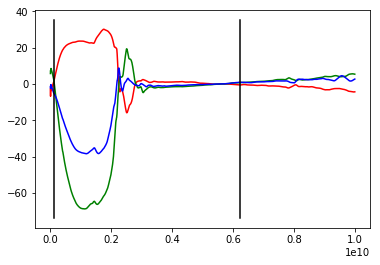

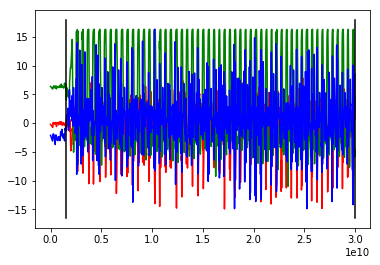

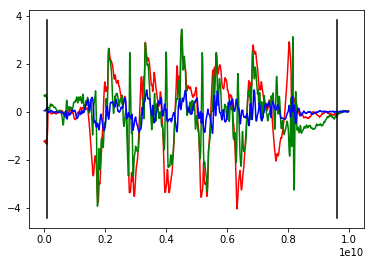

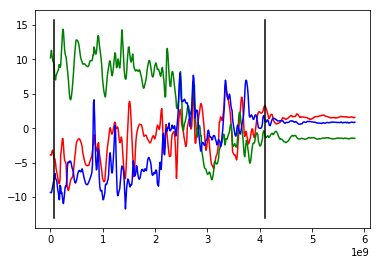

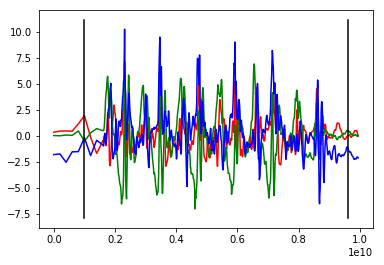

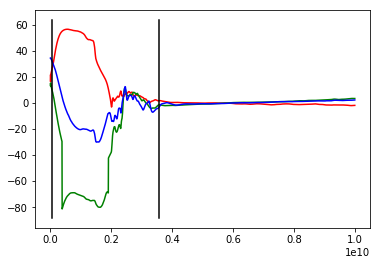

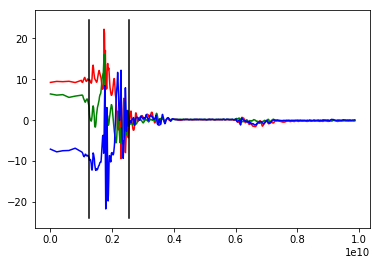

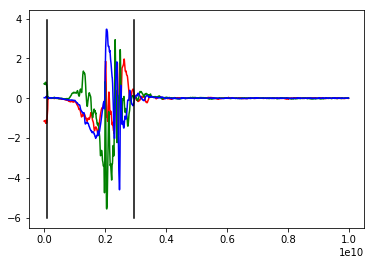

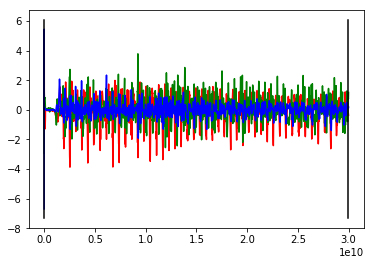

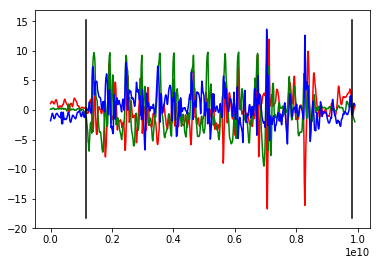

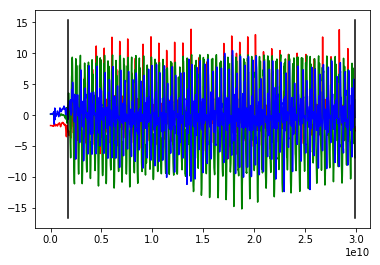

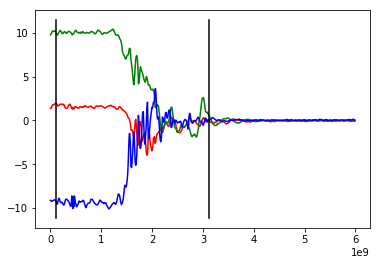

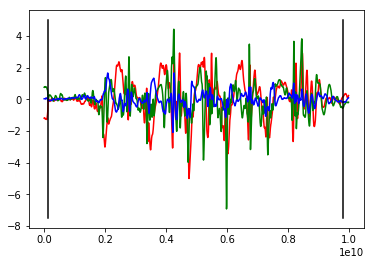

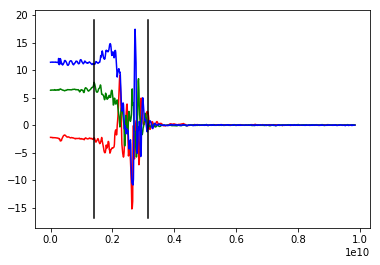

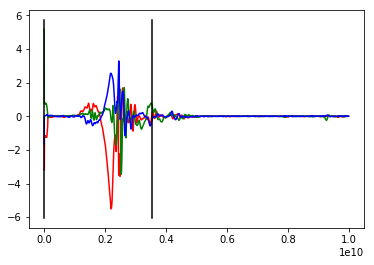

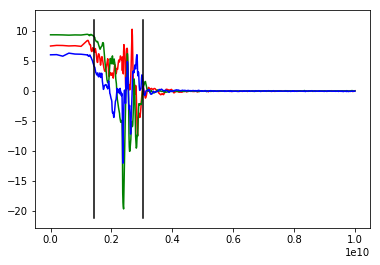

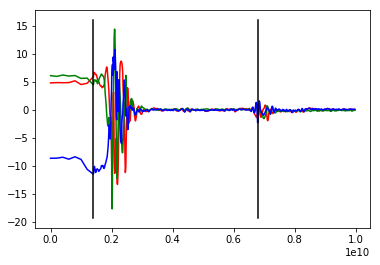

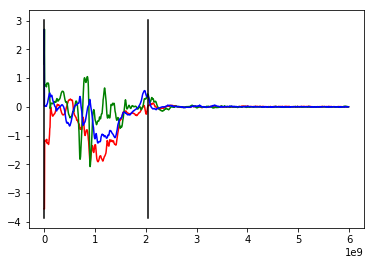

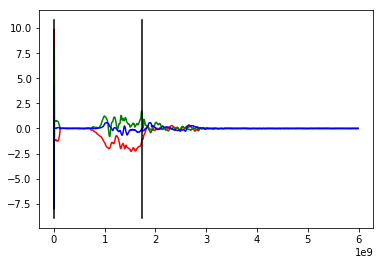

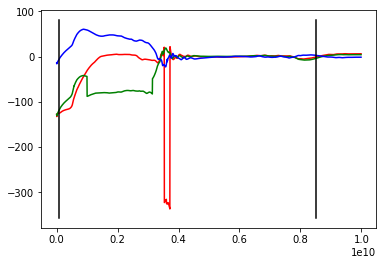

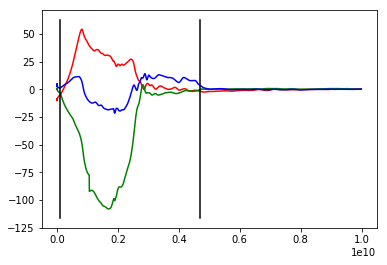

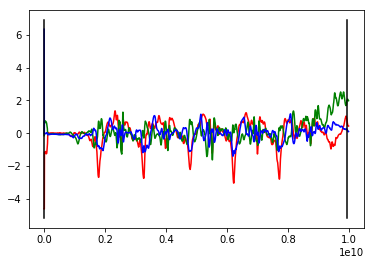

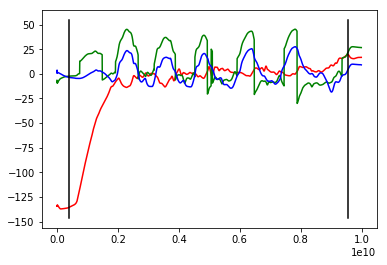

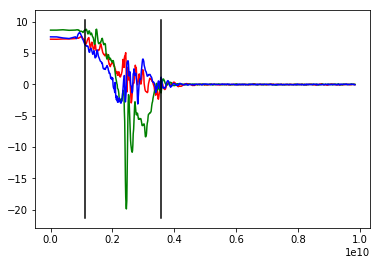

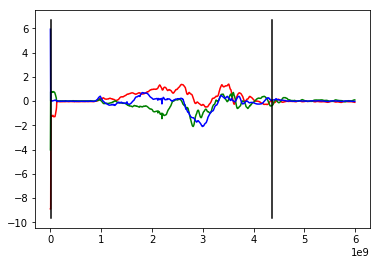

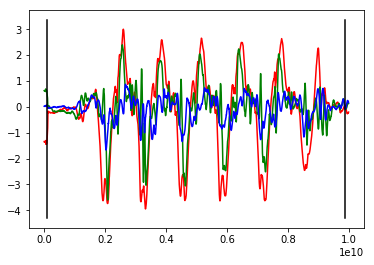

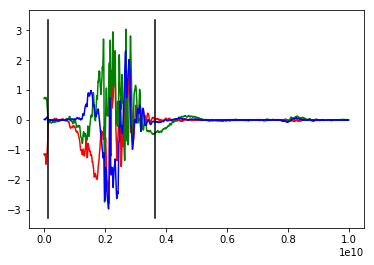

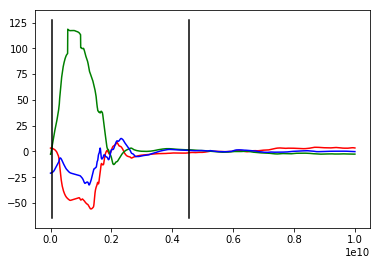

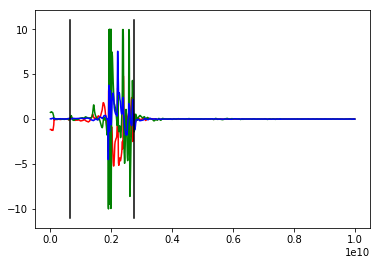

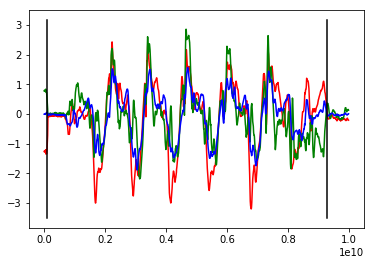

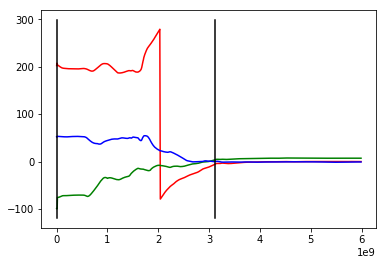

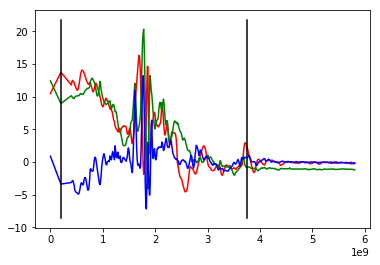

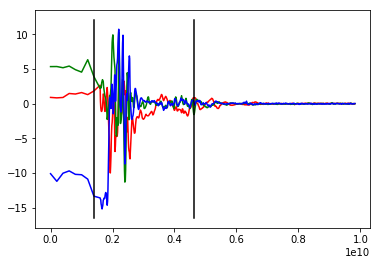

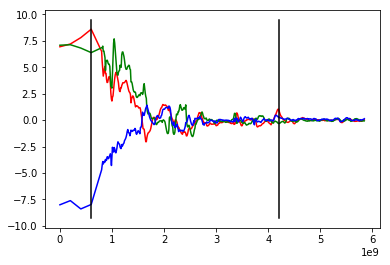

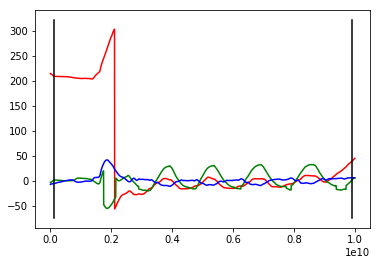

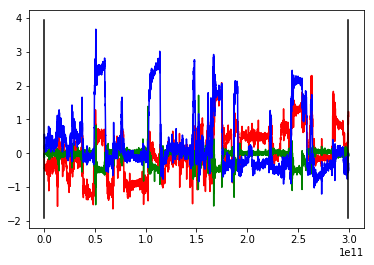

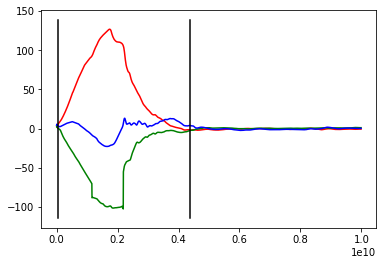

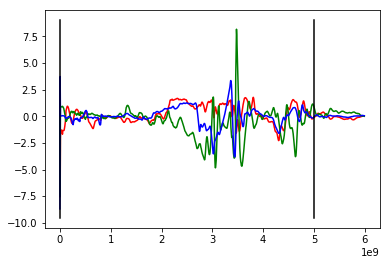

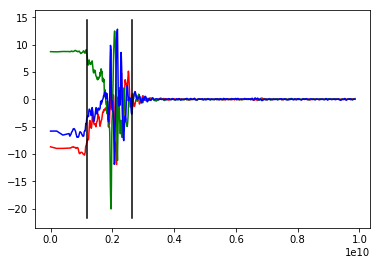

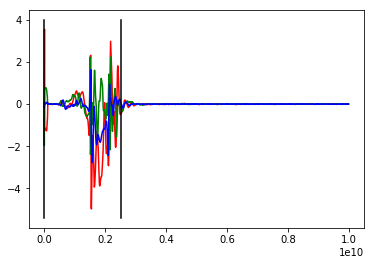

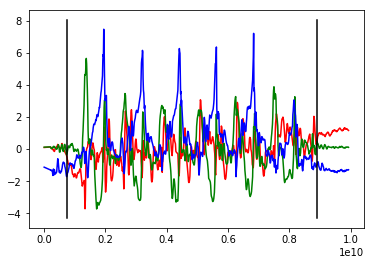

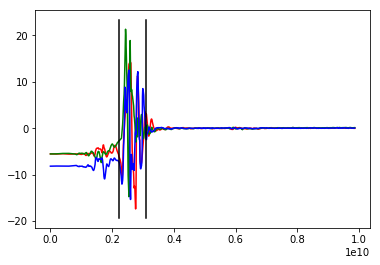

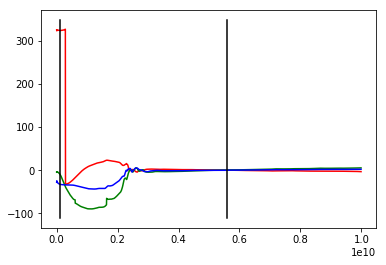

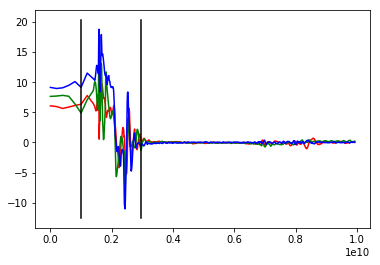

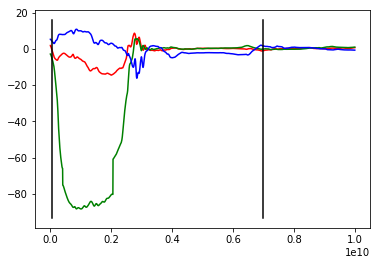

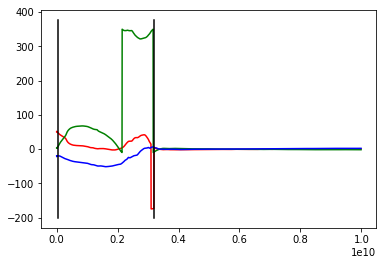

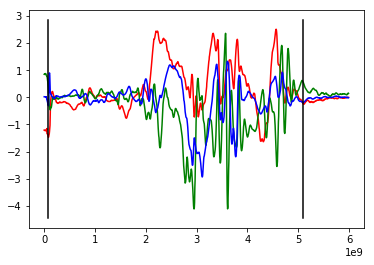

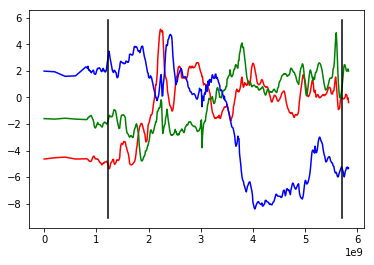

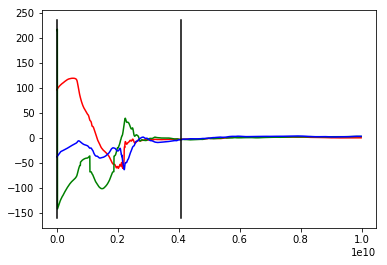

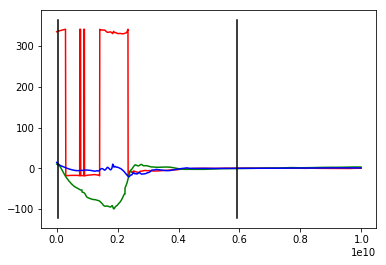

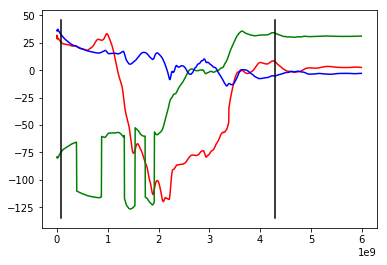

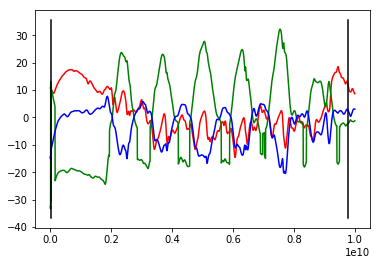

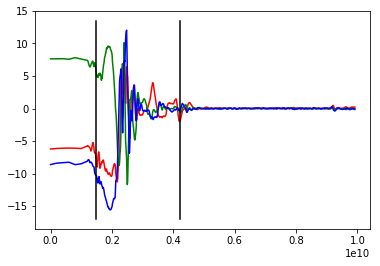

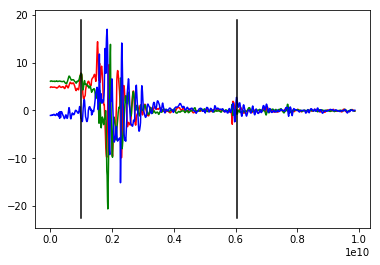

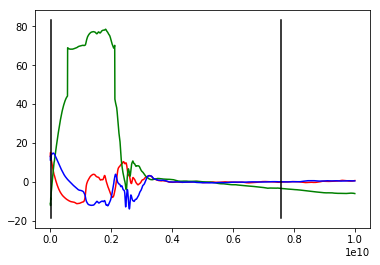

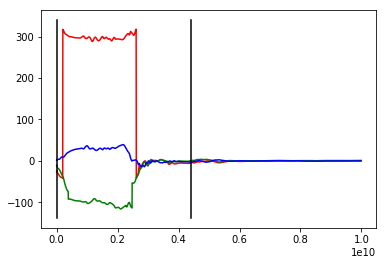

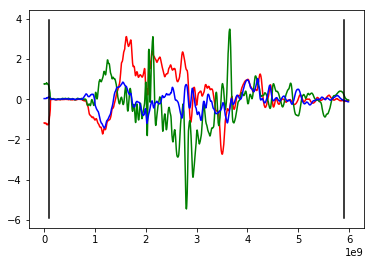

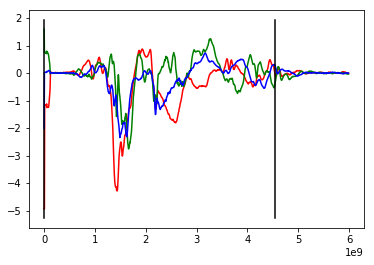

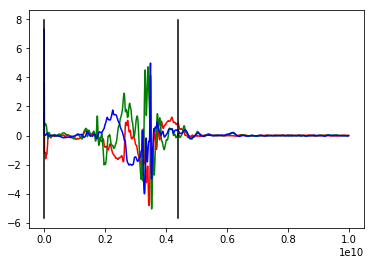

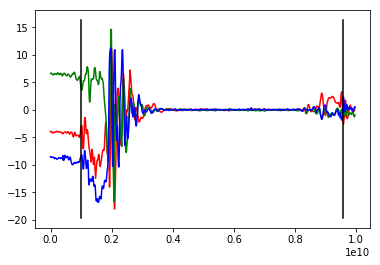

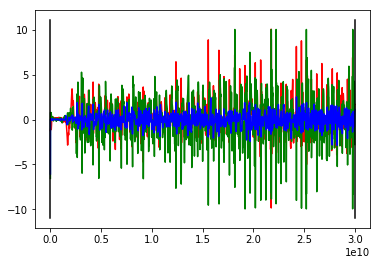

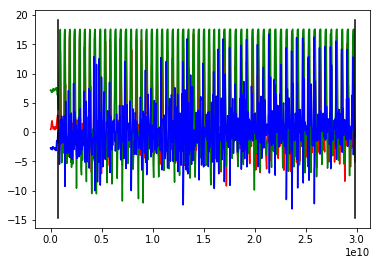

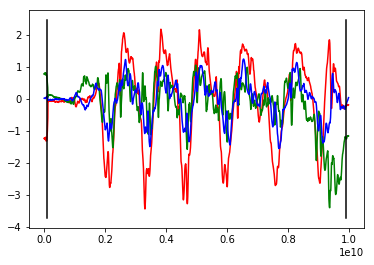

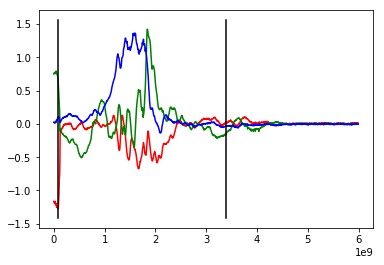

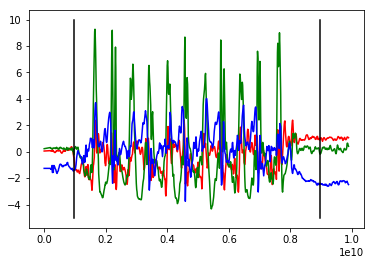

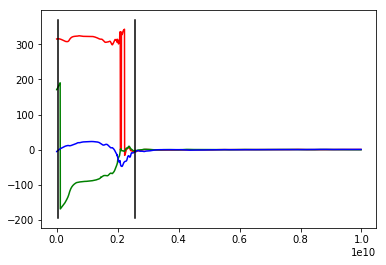

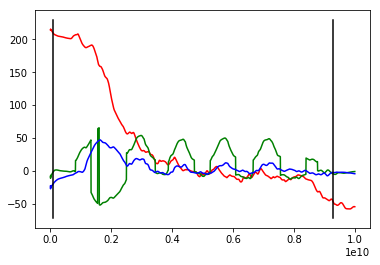

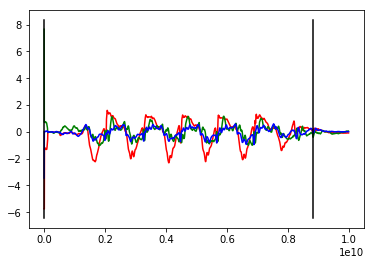

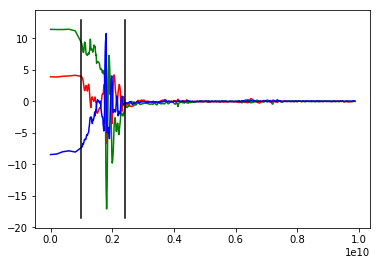

In [ ]:
root_dir = './MobiFall/'
categories = {}
durations = []
starts = []
ends = []
for file in [i for i in os.listdir(root_dir)]:
    prefix = file[0:3]
    if prefix not in categories:
        obj = {}
        obj['durations'] = []
        obj['starts'] = []
        obj['ends'] = []
        categories[prefix] = obj
    data, domain = parse_data(root_dir + file)
    categories[prefix]['durations'].append(data['duration'])
    categories[prefix]['starts'].append(domain[0] / data['duration'])
    categories[prefix]['ends'].append(domain[1] / data['duration'])
    plot_data(data, domain)

for prefix in categories:
    plt.hist(categories[prefix]['starts'], bins=40)
    plt.title(prefix+' start')
    plt.show()
    plt.hist(categories[prefix]['ends'], bins=40)
    plt.title(prefix+' end')
    plt.show()
    plt.hist(categories[prefix]['durations'], bins=30)
    plt.title(prefix+' duration')
    plt.show()

In [ ]:
trims = [(),